# 1. SHAP Analysis

This notebook focuses on the explainability of machine learning models using SHAP (SHapley Additive exPlanations) values. SHAP values provide insights into the contribution of each feature to the model's predictions, helping to understand the importance and impact of different features.

## Packages and Data

The notebook begins by importing necessary packages, including pandas, matplotlib, and SHAP. Additionally, a custom helper module called `figs_helper` is imported, which likely contains additional functions for generating figures.

Next, the data is loaded into a pandas DataFrame from a specified directory. Various preprocessing steps are performed on the data, such as converting data types and handling missing values.

## Model Evaluation

The notebook proceeds to evaluate the explainability of two models: a simple logistic regression model and a complex XGBoost model.

### Simple Model

#### Coefficients

The logistic regression model's coefficients are loaded from a file, and a function called `calculate_coefficient` is used to process and visualize the coefficients. The resulting coefficients and a figure are displayed.

#### SHAP Values

The SHAP values for the logistic regression model are loaded from a file, and a function called `calculate_shap` is used to process and visualize the SHAP values. The `shap.summary_plot` function is used to create a summary plot of the SHAP values, and a figure is displayed. Additionally, scatter plots of the SHAP values for individual features (`start_glc` and `duration`) are created and displayed.

### Complex Model

The SHAP values for the XGBoost model are loaded from a file, and the `calculate_shap` function is used to process and visualize the SHAP values. Similar to the simple model, a summary plot of the SHAP values is created and displayed using `shap.summary_plot`. Additionally, dependence plots showing the relationship between individual features and their corresponding SHAP values are created and displayed using the `figs.dependence_plots` function.

This notebook provides an overview of how SHAP values can be used to interpret and explain machine learning models, allowing for a deeper understanding of the models' decision-making processes.


## 1.0. Packages and data

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import explain_helper

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load data from logistic regression (all features)
with open("../../results/dict_results/lr_results_all", "rb") as fp:   
    #Unpickling 
    lr_ts_results = pickle.load(fp)

In [3]:
# Load data from XGBoost (all features)
with open("../../results/dict_results/xgb_ts", "rb") as fp:   
    #Unpickling 
    xgb_ts_results = pickle.load(fp)

## 1.1. XGBoost

In [14]:
# Get the shap values from the dict
shap_values = xgb_ts_results['shap']

# Calculate the average shap values from the k-folds
shap_avgs = explain_helper.mean_shap(shap_values)

In [44]:
# Original column names
cols_of_interest = ['start_glc', 
                   'duration', 
                   'form_of_exercise_aer',
                   'start_roc',
                   'time_of_day_morning',  
                   'glc__minimum',
                   'hba1c', 
                   'years_since_diagnosis',
                   'bmi',
                   'intensity', 
                   'CV (%)',
                   'LBGI',
                   'HBGI',
                   'glc__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)',
                   'glc__mean_second_derivative_central',
                   'glc__fft_coefficient__attr_"angle"__coeff_4',
                   #'glc__partial_autocorrelation__lag_2',
                   #'glc__approximate_entropy__m_2__r_0.9',
                   #'glc__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
                   #'glc__fft_coefficient__attr_"imag"__coeff_4',
                   #'glc__fft_coefficient__attr_"angle"__coeff_3',
                   #'glc__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
                   
                   #'glc__fft_coefficient__attr_"angle"__coeff_2',
                   #'glc__fft_coefficient__attr_"real"__coeff_6',
                  ]

# New column names
col_names = ['Start glucose (mmol/L)',
            'Duration (mins)', 
            'Aerobic exercise', 
            'Starting rate of change (mmol/L/hour)',
            'Time of day (morning)', 
            'Minimum glucose 1hr prior (mmol/L)',
            'HbA1c (mmol/mol)', 
            'Years since diagnosis',
            r'BMI (kg/m$^2$)'  , 
            'Intensity', 
            'CV 1hr prior (%)', 
            'LBGI 1hr prior', 
            'HBGI 1hr prior',
            'tsfresh Feature 1',
            'tsfresh Feature 2',
            'tsfresh Feature 3',
            #'tsfresh Feature 4',
            #'tsfresh Feature 5',
            #'tsfresh Feature 6',
            #'tsfresh Feature 7',
            #'tsfresh Feature 8',
            #'tsfresh Feature 9',
            #'tsfresh Feature 10',
            #'tsfresh Feature 11'
                  ]

# Create dict with old and new col names
name_mapping = dict(zip(cols_of_interest, col_names))

In [45]:
# Get X from the dict
X_complex = xgb_ts_results['X'].copy()

# Rename cols
X_complex = X_complex.rename(columns=name_mapping)

### 1.1.1 Summary plot

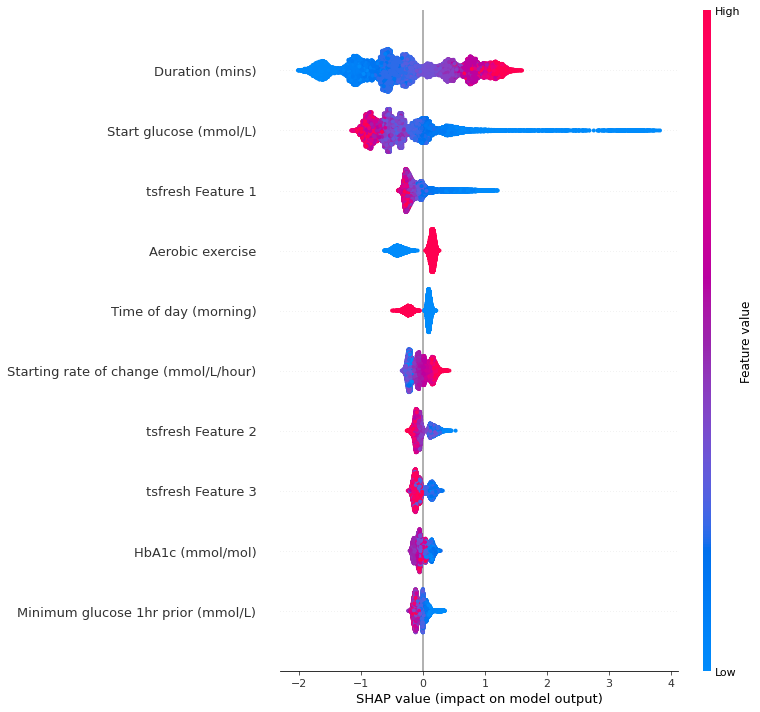

In [50]:
# Create fig
fig, ax = plt.subplots(figsize=(11,10))
ax = shap.summary_plot(shap_avgs, X_complex, plot_size=None, feature_names=list(X_complex.columns), max_display=10)
fig.savefig('../../results/figs/suppl_fig_2.pdf')


### 1.1.2. Dependence plot with clinically relevant features

In [17]:
X = xgb_ts_results['X']

In [18]:
feature_importance = pd.DataFrame(list(zip(X.columns,
                                               sum(shap_avgs.values))), #
                                      columns=['col_name',
                                               'feature_importance_vals'])

In [19]:
feature_importance["feature_importance_vals"] = np.abs(feature_importance["feature_importance_vals"])

feature_importance.sort_values(by=['feature_importance_vals'],
                                   ascending=False,inplace=True)

In [20]:
feature_importance[~feature_importance['col_name'].str.startswith('glc_')].head(20)

,col_name,feature_importance_vals
2,duration,3898.597900
3,start_glc,3743.290771
4,start_roc,675.311584
399,form_of_exercise_aer,625.922607
398,time_of_day_morning,286.656067
6,hba1c,164.160751
14,AUC (mmol h/L),142.948669
15,LBGI,122.724037
7,bmi,107.234512
13,CV (%),74.272774


In [21]:
X_complex['Intensity'] = X_complex['Intensity'].replace({0:'Light', 1:'Moderate', 2:'Vigorous'})
X_complex['Aerobic exercise'] = X_complex['Aerobic exercise'].replace({0:'No', 1:'Yes'})
X_complex['Time of day (morning)'] = X_complex['Time of day (morning)'].replace({0:'No', 1:'Yes'})
X_complex['Starting rate of change (mmol/L/hour)'] = (X_complex['Starting rate of change (mmol/L/hour)']*-1)
#X_complex['Start glucose (mg/dL)'] = X_complex['Start glucose (mg/dL)']*18

In [60]:
cols_of_interest = ['start_glc', 
                   'duration', 
                   'start_roc',
                    'form_of_exercise_aer',

                   'time_of_day_morning',  
                   'hba1c', 
                   #'years_since_diagnosis',
                   'bmi',
                   'intensity', ]

In [53]:
cols_of_interest = ['Start glucose (mmol/L)', 'Starting rate of change (mmol/L/hour)', 'Aerobic exercise', 'Time of day (morning)', 'Duration (mins)', 'Intensity' ]

In [31]:
color_1 = (96/255, 108/255, 158/255)

In [63]:
%%capture
fig, axes = plt.subplots(4,2, figsize=(12, 16))
for i, ax in enumerate(axes.flat):
    col_name = cols_of_interest[i]
    _ = shap.plots.scatter(shap_avgs[:,col_name], ax=ax, color=color_1) #, color='orange'
    
    # Add label on the top left of each plot
    label = chr(65 + i)  # A, B, C, ...
    ax.text(0, 1.02, label, transform=ax.transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)
    
    if col_name in name_mapping:
        ax.set_xlabel(name_mapping[col_name])
    # Setting y-axis label
    ax.set_ylabel("SHAP value")

fig.tight_layout()

fig.savefig('../../results/figs/suppl_fig_3.jpeg')


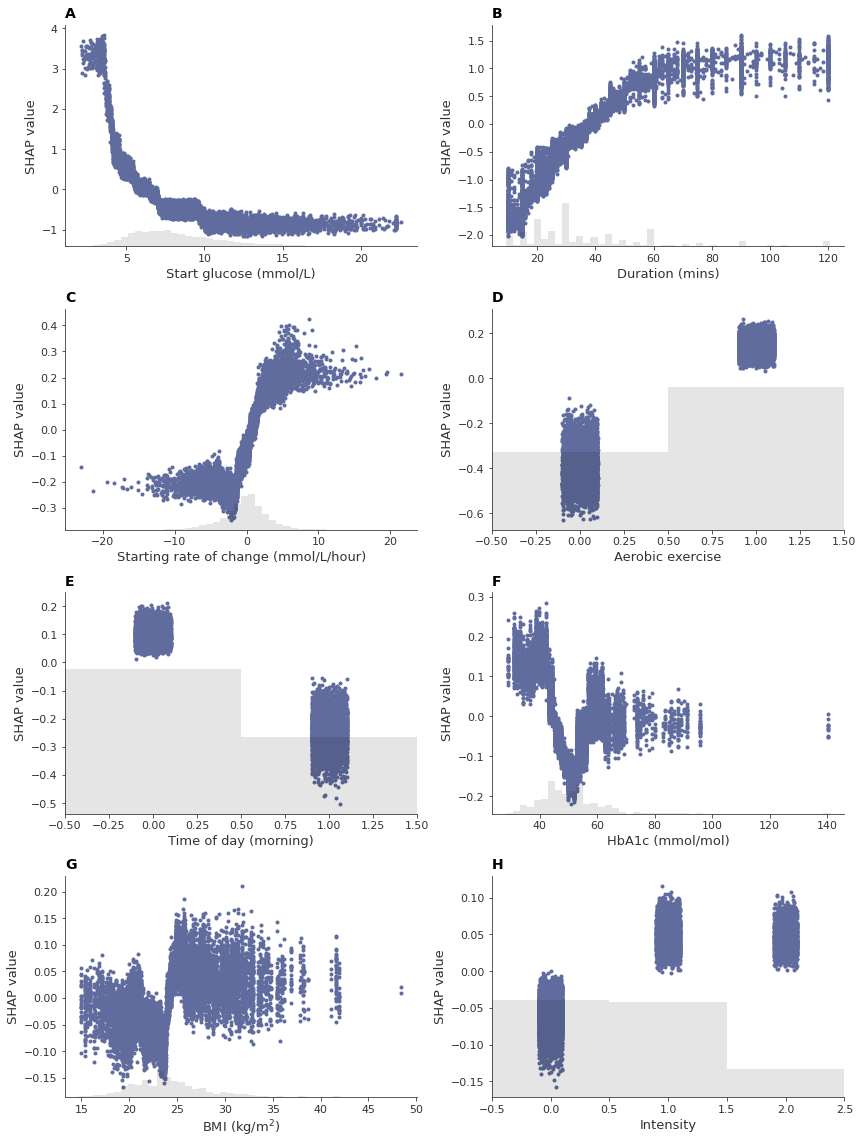

In [64]:
fig

## 1.2. Logistic regression

### 1.2.1. Coefficients
The logistic regression model's coefficients are loaded from a file, and a function called `calculate_coefficient` is used to process and visualize the coefficients. The resulting coefficients and a figure are displayed.

In [15]:
coeffs = lr_ts_results['coeffs']
X_lr = lr_ts_results['X']

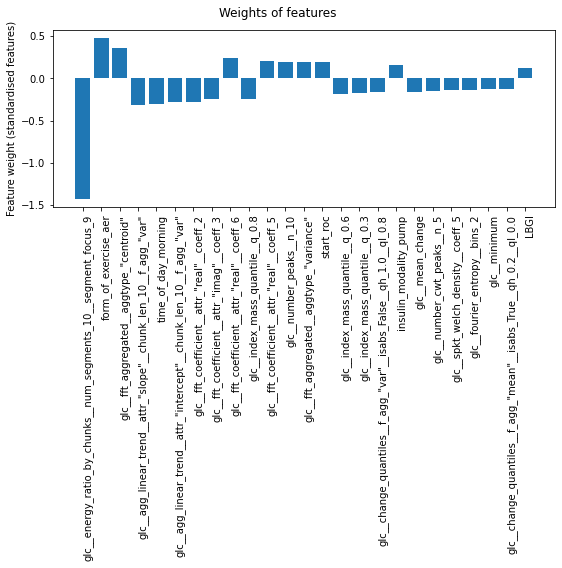

In [16]:
log_weights, fig = explain_helper.calculate_coefficient(coeffs, X_lr.columns)

In [17]:
log_weights

,feature,weights,abs_weight
366,glc__energy_ratio_by_chunks__num_segments_10__...,-1.429739,1.429739
405,form_of_exercise_aer,0.475246,0.475246
301,"glc__fft_aggregated__aggtype_""centroid""",0.359292,0.359292
342,"glc__agg_linear_trend__attr_""slope""__chunk_len...",-0.314868,0.314868
404,time_of_day_morning,-0.305094,0.305094
...,...,...,...
191,glc__cwt_coefficients__coeff_7__w_5__widths_(2...,0.000000,0.000000
192,glc__cwt_coefficients__coeff_7__w_10__widths_(...,0.000000,0.000000
204,glc__cwt_coefficients__coeff_10__w_10__widths_...,0.000000,0.000000
205,glc__cwt_coefficients__coeff_10__w_20__widths_...,0.000000,0.000000


In [18]:
log_weights[~log_weights['feature'].str.startswith('glc_')].head(12)

,feature,weights,abs_weight
405,form_of_exercise_aer,0.475246,0.475246
404,time_of_day_morning,-0.305094,0.305094
3,start_roc,0.189422,0.189422
412,insulin_modality_pump,0.155109,0.155109
14,LBGI,0.122316,0.122316
2,start_glc,-0.102298,0.102298
403,time_of_day_evening,0.083818,0.083818
0,intensity,0.067236,0.067236
415,season_3.0,-0.053369,0.053369
1,duration,0.022668,0.022668


### 1.2.2. SHAP values
The SHAP values for the logistic regression model are loaded from a file, and a function called `calculate_shap` is used to process and visualize the SHAP values. The `shap.summary_plot` function is used to create a summary plot of the SHAP values, and a figure is displayed. Additionally, scatter plots of the SHAP values for individual features (`start_glc` and `duration`) are created and displayed.

In [19]:
shap_values_lr = lr_ts_results['shap']

In [20]:
shap_avgs_lr = explain_helper.mean_shap(shap_values_lr)

In [21]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_avgs_lr, X_lr)

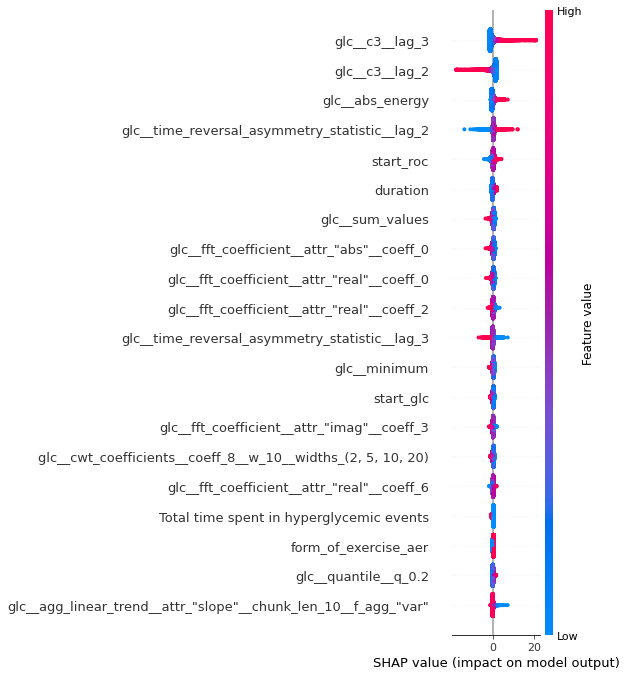

In [22]:
fig